In [173]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from __future__ import print_function
import numpy as np 
import os
import glob
import numpy as np 
import skimage.io as io
import skimage.transform as trans
from skimage import feature
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from sklearn.model_selection import GridSearchCV, train_test_split,StratifiedShuffleSplit
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from IPython.display import clear_output
from sklearn.svm import LinearSVC
from sklearn.metrics import jaccard_score
from time import time
from mpl_toolkits.mplot3d import Axes3D




In [3]:
def load_images_from_folder(folder):
    images = []
    img_list = os.listdir(folder)
    img_list.sort()
    for filename in img_list:
        img = io.imread(os.path.join(folder,filename))
        img = img / 255
        images.append(img)
    return images

def create_data(images,masks):
  rows = images[0].shape[0]
  cols = images[0].shape[1]
  dim =  images[0].ndim 
  if dim == 3:
    X = images[0].reshape(rows*cols, dim)
  else:
    X = images[0].reshape(rows*cols)

  Y = masks[0].reshape(rows*cols)

  for i in range(1,len(masks)):
    clear_output(wait=True)
    if dim == 3:
      img = images[i].reshape(rows*cols, dim)
      X = np.vstack((X,img))

    else:
      img = images[i].reshape(rows*cols)
      X = np.hstack((X,img))


    mask = masks[i].reshape(rows*cols)
    Y = np.hstack((Y,mask))

    print("Current Progress : ",np.round(i/len(masks)*100,2),"%")

  return X,Y

def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_


def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_


def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")




In [4]:
S1_masks = load_images_from_folder('/content/drive/MyDrive/OmbriaS1/train/MASK')
S2_images = load_images_from_folder('/content/drive/MyDrive/OmbriaS2/train/AFTER')
S2_images_b = load_images_from_folder('/content/drive/MyDrive/OmbriaS2/train/BEFORE')

S1_images = load_images_from_folder('/content/drive/MyDrive/OmbriaS1/train/AFTER')
S1_images_b= load_images_from_folder('/content/drive/MyDrive/OmbriaS1/train/AFTER')

y_true = load_images_from_folder('/content/drive/MyDrive/OmbriaS2/test/MASK')
S2_x_true = load_images_from_folder('/content/drive/MyDrive/OmbriaS2/test/AFTER')
S2_x_true_b = load_images_from_folder('/content/drive/MyDrive/OmbriaS2/test/BEFORE')

S1_x_true = load_images_from_folder('/content/drive/MyDrive/OmbriaS1/test/AFTER')
S1_x_true_B = load_images_from_folder('/content/drive/MyDrive/OmbriaS1/test/BEFORE')


In [5]:
X2_train,Y_train = create_data(S2_images,S1_masks)
X2_train_b,_ = create_data(S2_images_b,S1_masks)
X2_test,Y_test = create_data(S2_x_true,y_true)
X2_test_b,_ = create_data(S2_x_true_b,y_true)





Current Progress :  98.57 %


(40894464, 3)

In [6]:
X1_train, _ = create_data(S1_images,S1_masks)
X1_train_b,_ = create_data(S1_images_b,S1_masks)
X1_test,_ = create_data(S1_x_true,y_true)
X1_test_b,_ = create_data(S1_x_true_B,y_true)

Current Progress :  98.57 %


In [32]:
X = np.column_stack((X2_train,X2_train,X1_train,X1_train_b))
X_test = np.column_stack((X2_test,X2_test,X2_test,X2_test_b))



In [35]:
X = X
Y = Y_train

In [36]:
x, x_val, y,  y_val = train_test_split(X, Y, test_size=0.1, random_state=43)

In [37]:
import warnings
warnings.filterwarnings("ignore")
 
t0=time()

clf = LinearSVC(dual=False, C=10, tol=1e-4)
clf.fit(x,y)
t1 = time()
print ("training time:", round(t1-t0, 3) )
#clf = svm.SVC( kernel='linear',gamma=0.0001 ,verbose=10)
#clf = GridSearchCV(svc, param_grid)
#clf.fit(X_train, y_train)

training time: 88.364


In [67]:
print(round(clf.score(x,y),4))
print(round(clf.score(x_val,y_val),4))

0.7996
0.7998


In [12]:
y_pred = clf.predict(X_test)
#supervised = y.reshape(rows, cols)

In [49]:
y_pred.shape

(4587520,)

In [50]:
rows,cols = y_true[0].shape

predictions = []
for  i in range(0,len(y_true)):
  first = y_pred[rows*cols*i:rows*cols*(i+1)].reshape(rows,cols)
  predictions.append(first)



In [51]:
pix_acc = []
mean_IoU = []
FW_IoU =[]

for i in range(0,len(y_true)):

  pix_acc.append(round(pixel_accuracy(predictions[i], y_true[i]),5))
  mean_IoU.append(round(jaccard_score(y_true[i].ravel(), predictions[i].ravel(),average ='macro'),5))
  FW_IoU.append(round(frequency_weighted_IU(predictions[i], y_true[i]),5))

print( pix_acc)
print(mean_IoU) 
print(FW_IoU) 

average_pix_acc = sum(pix_acc) / len(pix_acc)
average_IoU = (sum( mean_IoU)/len( mean_IoU))
average_FW_IoU = (sum( FW_IoU)/len( FW_IoU))

print('Average Pixel Accuracy : ' + str(round(average_pix_acc, 4)) )
print('Mean IoU : ' + str(round(average_IoU , 4)) )   
print('FW IoU : ' + str(round(average_FW_IoU  , 4))  )
#print ("training time:", round((t1-t0)/60, 2) )
indexes = np.argsort(pix_acc)

[0.95822, 0.86279, 0.8566, 0.28748, 0.92061, 0.83902, 0.92854, 0.92201, 0.72954, 0.83821, 0.78958, 0.92496, 0.66096, 0.79265, 0.88292, 0.52711, 0.66013, 0.59111, 0.85295, 0.88937, 0.8127, 0.9534, 0.86224, 0.95018, 0.97444, 0.9118, 0.88376, 0.91658, 0.91502, 0.94281, 0.93753, 0.87563, 0.94244, 0.90572, 0.77698, 0.75427, 0.84183, 0.92792, 0.80775, 0.90445, 0.85063, 0.94525, 0.87469, 0.8669, 0.86703, 0.90471, 0.95161, 0.89034, 0.85077, 0.93724, 0.97861, 0.89633, 0.90868, 0.96548, 0.80283, 0.68892, 0.7869, 0.64134, 0.69986, 0.73276, 0.71977, 0.79199, 0.89259, 0.97083, 0.96255, 0.96684, 0.91417, 0.9297, 0.91046, 0.84242]
[0.74974, 0.59775, 0.55489, 0.14599, 0.46315, 0.41951, 0.46427, 0.46101, 0.46461, 0.71239, 0.51195, 0.73754, 0.4351, 0.42658, 0.60664, 0.31966, 0.35373, 0.38847, 0.47039, 0.44469, 0.6775, 0.50198, 0.62844, 0.84691, 0.82392, 0.66585, 0.77669, 0.80715, 0.64752, 0.49351, 0.71266, 0.75063, 0.53238, 0.60641, 0.5989, 0.4622, 0.65746, 0.46396, 0.62927, 0.82434, 0.72487, 0.87765, 0

Text(0.5, 1.0, 'Prediction')

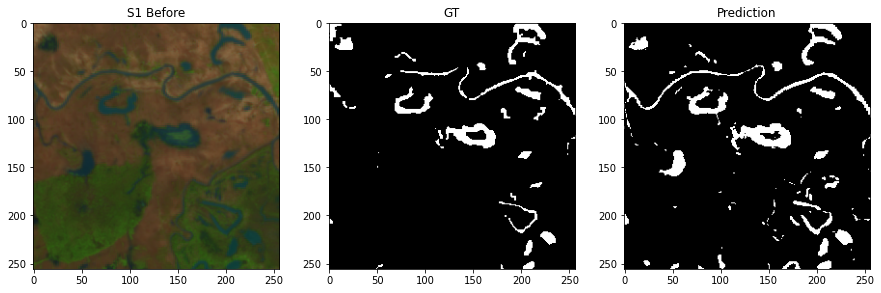

In [ ]:
index = 0
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(S2_x_true[index],cmap=plt.cm.gray)
ax.set_title('S1 Before')
ax = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(y_true[index],cmap=plt.cm.gray)
ax.set_title('GT')
ax = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(predictions[index],cmap=plt.cm.gray)
ax.set_title('Prediction')


In [ ]:
save_path = '/content/drive/MyDrive/flood_mapping/NEW/SVM/BITEMPORAL/S1/'


lista = os.listdir('/content/drive/MyDrive/OmbriaS2/test/MASK')
lista.sort()
for i in range(0,len(lista)):
  im = Image.fromarray((predictions[i]*255).astype(np.uint8))
  im.save(save_path + "PREDICTIONS/MULTIMODALSVMprediction_"+ lista[i][-8:])


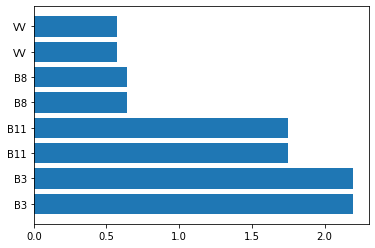

In [51]:
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called
features_names = ['B11', 'B8','B3','B11', 'B8','B3','VV','VV'] 

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importances(abs(clf.coef_[0]), features_names, top=8)

In [ ]:

from sklearn.decomposition import PCA

# initialize algorithms and data with random

pca = PCA(n_components = 2)

pca.fit(x_val,y_val)
U2 = pca.fit_transform(U,v)
model.fit(U2,v)

# generate grid for plotting
h = 0.2
x_min, x_max = U2[:,0].min() - 1, U2[:, 0].max() + 1
y_min, y_max = U2[:,1].min() - 1, U2[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))

# create decision boundary plot
Z = s.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
contourf(xx,yy,Z,cmap=plt.cm.coolwarm, alpha=0.8)
scatter(U2[:,0],U2[:,1],c=v)
show()

In [ ]:
from sklearn.decomposition import PCA
import pylab as pl

pca = PCA(n_components = 2).fit(x_val)
pca_2d = pca.transform(x_val)


for i in range(0, pca_2d.shape[0]):
  if y_val[i] == 0:
    c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',    marker='+')
  elif y_val[i] == 1:
    c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',    marker='o')